References:

Spatial Image Visuvalization: https://www.kaggle.com/soham1024/visualization-using-nilearn , https://nilearn.github.io/

For combining the features: https://www.kaggle.com/tunguz/rapids-randomforest-on-trends-neuroimaging

Deep Learning : https://www.youtube.com/results?search_query=jeff+heaton+deep

Keras baseline model : https://www.kaggle.com/kmatsuyama/simple-nn-baseline-using-keras

This is my first notebook in kaggle. I have read through multiple notebooks to understand the essence of this competition. I am still learning.
This notebook will be modified frequently. 

Positive critisims are most welcomed. I look forward to improving my skills. 

Incase anyone feels a part of their work is present and not sited feel free to add it to the comments, I will add it to the references list.

Hope this notebook would be useful!

In [3]:
import sys
!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage import measure
import seaborn as sns
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn import surface
import h5py
import plotly.graph_objs as go
from IPython.display import Image, display
import random
import os
import cudf
import cupy as cp

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [7]:
%%time
# Reading all the required files using pandas
loading_data = pd.read_csv("/kaggle/input/trends-assessment-prediction/loading.csv")
train_data = pd.read_csv('/kaggle/input/trends-assessment-prediction/train_scores.csv')
sample_submission = pd.read_csv('/kaggle/input/trends-assessment-prediction/sample_submission.csv')
fnc = pd.read_csv('/kaggle/input/trends-assessment-prediction/fnc.csv')
ICN_numbers = pd.read_csv('/kaggle/input/trends-assessment-prediction/ICN_numbers.csv')
reveal_ID_site2 = pd.read_csv('/kaggle/input/trends-assessment-prediction/reveal_ID_site2.csv')

CPU times: user 4.19 s, sys: 207 ms, total: 4.4 s
Wall time: 4.41 s


In [6]:
%%time
# Reading all the required files using cudf
loading_data = cudf.read_csv("/kaggle/input/trends-assessment-prediction/loading.csv")
train_data = cudf.read_csv('/kaggle/input/trends-assessment-prediction/train_scores.csv')
sample_submission = cudf.read_csv('/kaggle/input/trends-assessment-prediction/sample_submission.csv')
fnc = cudf.read_csv('/kaggle/input/trends-assessment-prediction/fnc.csv')
ICN_numbers = cudf.read_csv('/kaggle/input/trends-assessment-prediction/ICN_numbers.csv')
reveal_ID_site2 = cudf.read_csv('/kaggle/input/trends-assessment-prediction/reveal_ID_site2.csv')

CPU times: user 1.4 s, sys: 897 ms, total: 2.29 s
Wall time: 2.53 s


In [8]:
# Understanding the structure of the given files
print('The shape of loading data is =',loading_data.shape)
print('The shape of training scores is =',train_data.shape)
print('The shape of sample submission is =',sample_submission.shape)
print('The shape of fnc data is =',fnc.shape)
print('The shape of ICN numbers data is =',ICN_numbers.shape)
print('The shape of reveal Id site2 is =',reveal_ID_site2.shape)
print('')

The shape of loading data is = (11754, 27)
The shape of training scores is = (5877, 6)
The shape of sample submission is = (29385, 2)
The shape of fnc data is = (11754, 1379)
The shape of ICN numbers data is = (53, 1)
The shape of reveal Id site2 is = (510, 1)



In [9]:
# Data Pre-Processing

# Checking for missing data
# Training Data
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print('')
print('\n','Missing Training Data','\n',missing_train_data.head())

# Loading Data
total = loading_data.isnull().sum().sort_values(ascending = False)
percent = (loading_data.isnull().sum()/loading_data.isnull().count()*100).sort_values(ascending = False)
missing_loading_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print('')
print('Missing Loading Data','\n',missing_loading_data.head())# No null values

# fnc Data
total = fnc.isnull().sum().sort_values(ascending = False)
percent = (fnc.isnull().sum()/fnc.isnull().count()*100).sort_values(ascending = False)
missing_fnc_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print('')
print('Missing FNC Data','\n',missing_fnc_data.head())# No null values



 Missing Training Data 
               Total   Percent
domain1_var2    438  7.452782
domain1_var1    438  7.452782
domain2_var2     39  0.663604
domain2_var1     39  0.663604
age               0  0.000000

Missing Loading Data 
        Total  Percent
IC_14      0      0.0
IC_24      0      0.0
IC_01      0      0.0
IC_07      0      0.0
IC_05      0      0.0

Missing FNC Data 
                    Total  Percent
CBN(7)_vs_CBN(4)       0      0.0
CON(67)_vs_SMN(2)      0      0.0
CON(63)_vs_SMN(2)      0      0.0
CON(79)_vs_SMN(2)      0      0.0
CON(84)_vs_SMN(2)      0      0.0


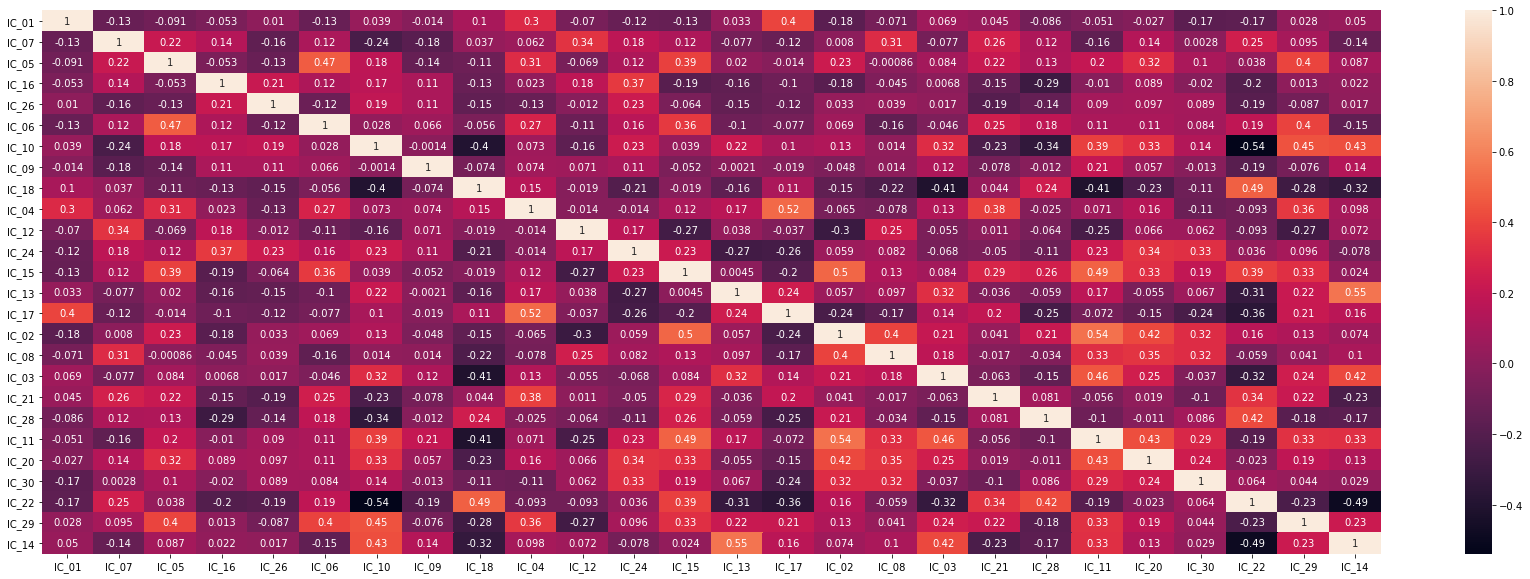

In [10]:
#Using a heat-map to understand correlation between vaiables
map_data =  loading_data.drop(['Id'], axis=1)
plt.figure(figsize = (30, 10))
sns.heatmap(map_data.corr(), annot = True)
plt.yticks(rotation=0) 
plt.show()

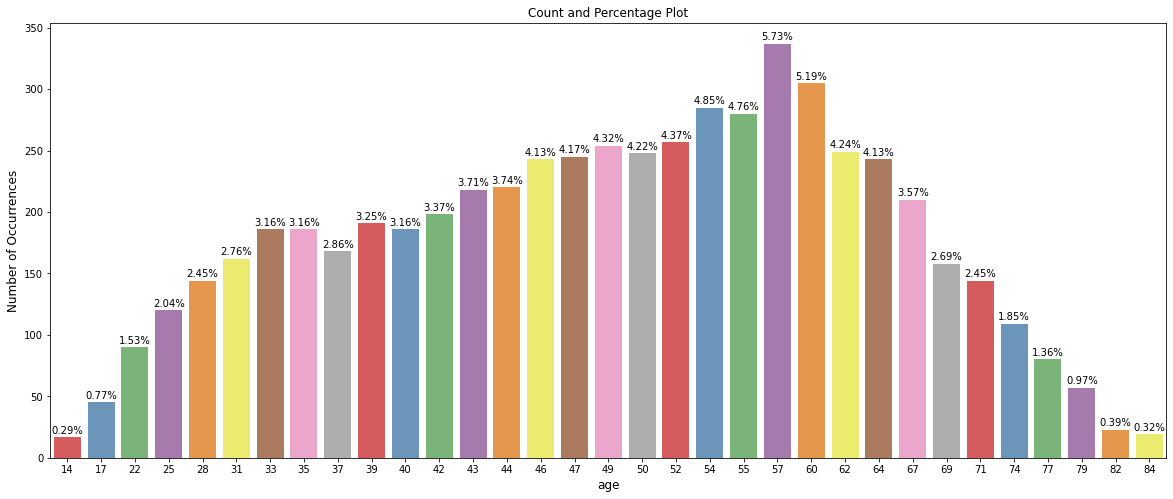

In [11]:
#Using a bar plot to understand the overall distribution
#Helper Fuction to plot a bar graph
def plot_bar(df, feature, title='', show_percent = False, size=2):
    f, ax = plt.subplots(1,1, figsize=(5*size,2*size))
    total = float(len(df))
    sns.barplot(np.round(df[feature].value_counts().index).astype(int), df[feature].value_counts().values, alpha=0.8,orient='o', 
                palette='Set1')

    plt.title(title)
    if show_percent:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.0,
                    height + 3,
                    '{:1.2f}%'.format(100*height/total),
                    ha="center", rotation=0) 
    plt.xlabel(feature, fontsize=12, )
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xticks(rotation=0)
    plt.show()
plot_bar(train_data, 'age', 'Count and Percentage Plot', show_percent=True, size=4)

# Using nilearn to Visuvalize a few Spatial Maps

In [12]:
smri = '/kaggle/input/ch2better/ch2better.nii'# for better clarity
fmri_mask ='/kaggle/input/trends-assessment-prediction/fMRI_mask.nii'
mask_img = nl.image.load_img(fmri_mask)

def load_subject(filename, mask_img):
    subject_data = None
    with h5py.File(filename, 'r') as f:
        subject_data = f['SM_feature'][()]
    # It's necessary to reorient the axes, since h5py flips axis order
    subject_data = np.moveaxis(subject_data, [0,1,2,3], [3,2,1,0])
    subject_img = nl.image.new_img_like(mask_img, subject_data, affine=mask_img.affine, copy_header=True)

    return subject_img

Image shape is (53, 63, 52, 53)
Detected 53 spatial maps
--------------------------------------------------
Image shape is (53, 63, 52, 53)
Detected 53 spatial maps
--------------------------------------------------
Image shape is (53, 63, 52, 53)
Detected 53 spatial maps
--------------------------------------------------


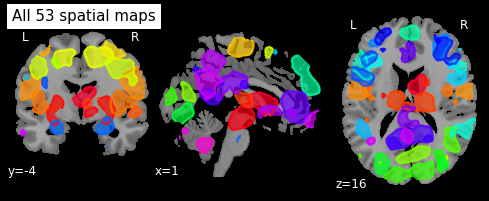

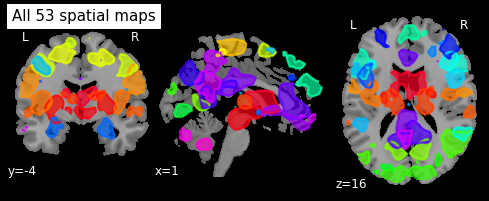

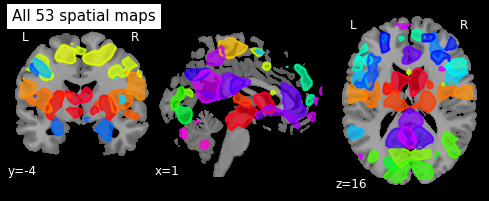

In [27]:
files = random.choices(os.listdir('/kaggle/input/trends-assessment-prediction/fMRI_train/'), k = 3)
for file in files:
    subject = os.path.join('/kaggle/input/trends-assessment-prediction/fMRI_train/', file)
    subject_img = load_subject(subject, mask_img)
    print("Image shape is %s" % (str(subject_img.shape)))
    num_components = subject_img.shape[-1]
    print("Detected {num_components} spatial maps".format(num_components=num_components))
    nlplt.plot_prob_atlas(subject_img, bg_img=smri, view_type='filled_contours',
                          draw_cross=False, title='All %d spatial maps' % num_components, threshold='auto')
    print("-"*50)

# Deep Neural Network for Predicting Age Using Keras

In [14]:
import os
from time import time
import math
import random
import gc
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Lambda
from keras.optimizers import Adam,SGD
from keras.callbacks import Callback
from numpy.random import seed
from keras.models import Sequential
from keras.layers import Dense, Activation
from time import gmtime, strftime
import cudf
import warnings
warnings.filterwarnings("ignore")
np.random.seed(1994)

In [16]:
%%time
# Re-importing using cudf for code clarity
train = pd.read_csv('../input/trends-assessment-prediction/train_scores.csv', dtype={'Id':str}).dropna().reset_index(drop=True) # to make things easy
reveal_ID = pd.read_csv('../input/trends-assessment-prediction/reveal_ID_site2.csv', dtype={'Id':str})
ICN_numbers = pd.read_csv('../input/trends-assessment-prediction/ICN_numbers.csv')
loading = pd.read_csv('../input/trends-assessment-prediction/loading.csv', dtype={'Id':str})
fnc = pd.read_csv('../input/trends-assessment-prediction/fnc.csv', dtype={'Id':str})
sample_submission = pd.read_csv('../input/trends-assessment-prediction/sample_submission.csv', dtype={'Id':str})
# dtype={'Id':str}->converting Id to string
#reset_index(drop=True)>We can use the drop parameter to avoid the old index being added as a column

CPU times: user 4.17 s, sys: 204 ms, total: 4.37 s
Wall time: 4.38 s


In [15]:
%%time
# Re-importing using cudf for code clarity
train = cudf.read_csv('../input/trends-assessment-prediction/train_scores.csv', dtypes={'Id':str}).dropna().reset_index(drop=True) # to make things easy
reveal_ID = cudf.read_csv('../input/trends-assessment-prediction/reveal_ID_site2.csv', dtypes={'Id':str})
ICN_numbers = cudf.read_csv('../input/trends-assessment-prediction/ICN_numbers.csv')
loading = cudf.read_csv('../input/trends-assessment-prediction/loading.csv', dtypes={'Id':str})
fnc = cudf.read_csv('../input/trends-assessment-prediction/fnc.csv', dtypes={'Id':str})
sample_submission = cudf.read_csv('../input/trends-assessment-prediction/sample_submission.csv', dtypes={'Id':str})
# dtype={'Id':str}->converting Id to string
#reset_index(drop=True)>We can use the drop parameter to avoid the old index being added as a column

CPU times: user 1.31 s, sys: 348 ms, total: 1.66 s
Wall time: 3.11 s


In [17]:
# Config
ID = 'Id'
y_cols = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
SEED = 26#https://www.geeksforgeeks.org/random-seed-in-python/

In [18]:
#lambda operator or lambda function is a way to create small anonymous functions, i.e. functions without a name
#lambda argument_list: expression

#>>> sum = lambda x, y : x + y
#sum(3,4)
#7

# >>> def sum(x,y):
# ...     return x + y
# ... 
# >>> sum(3,4)
# 7

#.apply()
#Pandas.apply allow the users to pass a function and apply it on every single value of the Pandas series

#The astype() function is used to cast a pandas object to a specified data type.

# It performs a blocking garbage collection of all generations. All objects, regardless of how long they have been in memory, 
# are considered for collection; however, objects that are referenced in managed code are not collected.
# Use this method to force the system to try to reclaim the maximum amount of available memory.

sample_submission['ID_num'] = sample_submission[ID].apply(lambda x: int(x.split('_')[0]))
test = pd.DataFrame({ID: sample_submission['ID_num'].unique().astype(str)})
del sample_submission['ID_num']; gc.collect()

62

In [19]:
#Removing unecessary fnc columns
fnc[fnc.columns[1:]] =fnc[fnc.columns[1:]]/600

In [20]:
# merge
train = train.merge(loading, on=ID, how='left')
train = train.merge(fnc, on=ID, how='left')

test = test.merge(loading, on=ID, how='left')
test = test.merge(fnc, on=ID, how='left')

In [21]:
print('Loading Columns : ', len(loading.columns))
print()
print('FNC Columns : ', len(fnc.columns))
print()
print('Train Columns : ', len(train.columns))

Loading Columns :  27

FNC Columns :  1379

Train Columns :  1410


In [22]:
#Normalizing data to enable smooth operation of optimizer and loss function (time saving)
from sklearn import preprocessing
def scaler(df):
    for i in range(5, len(df.columns)-5):
        col = df.iloc[:,i]
        col = preprocessing.minmax_scale(col)
    return df
train = scaler(train)
train = train.dropna(how='all').dropna(how='all', axis=1)
#“axis 0” represents rows and “axis 1” represents columns

In [23]:
X_train = train.drop('Id', axis=1).drop(y_cols, axis=1)
y_train = train.drop('Id', axis=1)[y_cols]
X_test = test.drop('Id', axis=1)
y_test=test.drop('Id', axis=1)

In [ ]:
# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('loss')<0.4):
#       print("\nReached 60% accuracy so cancelling training!")
#       self.model.stop_training = True

# callbacks = myCallback()

In [24]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))


In [25]:
epochs= 50
batch_size = 128
verbose = 1
validation_split = 0.3
input_dim = X_train.shape[1]
n_out = y_train.shape[1]
activation='selu'

model = keras.models.Sequential([
    keras.layers.Dense(2048,activation=activation,input_shape=(input_dim,)),#Normalized input layer
    keras.layers.Dense(1164,activation=activation),#Fully connected layers
    keras.layers.Dropout(0.8),
    keras.layers.Dense(512,activation=activation),
    keras.layers.Dense(128,activation=activation),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,activation=activation),
    keras.layers.Dense(32,activation=activation),
    keras.layers.Dense(16,activation=activation),
    keras.layers.Dense(n_out)#Output Layer
])



initial_learning_rate = 1e-3
step = tf.Variable(0, trainable=False)
learning_rate_fn = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps=100000,decay_rate=0.96,staircase=True)
lr_schedule = learning_rate_fn(step)

model.compile(loss='mse',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose =1 ,mode='min', patience =10)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor =0.2,min_lr =1e-6,patience = 10)

hist_1=model.fit(X_train, y_train,
                        batch_size = batch_size,epochs=epochs,
                        callbacks = [es,rp],
                        verbose=verbose, validation_split=validation_split)

model.summary()

Train on 3803 samples, validate on 1631 samples
Epoch 1/50
3803/3803 [==============================] - 1s 385us/step - loss: 1375.4125 - accuracy: 0.1964 - val_loss: 203.3516 - val_accuracy: 0.4672
Epoch 2/50
3803/3803 [==============================] - 0s 104us/step - loss: 200.0366 - accuracy: 0.3124 - val_loss: 142.4610 - val_accuracy: 0.4672
Epoch 3/50
3803/3803 [==============================] - 0s 100us/step - loss: 161.6916 - accuracy: 0.4002 - val_loss: 139.9076 - val_accuracy: 0.4672
Epoch 4/50
3803/3803 [==============================] - 0s 98us/step - loss: 155.6510 - accuracy: 0.4233 - val_loss: 138.1196 - val_accuracy: 0.4672
Epoch 5/50
3803/3803 [==============================] - 0s 100us/step - loss: 151.6468 - accuracy: 0.4304 - val_loss: 136.3188 - val_accuracy: 0.4672
Epoch 6/50
3803/3803 [==============================] - 0s 112us/step - loss: 149.0630 - accuracy: 0.4394 - val_loss: 136.7041 - val_accuracy: 0.4672
Epoch 7/50
3803/3803 [==============================

In [26]:
predicted_set = model.predict(X_test)
predicted_set = pd.DataFrame(predicted_set)
predicted_set.columns = y_train.columns
predicted_set.head(10)

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,59.353821,54.373001,60.840408,50.414108,52.140896
1,60.064507,54.211277,59.904343,50.341167,51.375637
2,33.779011,45.638535,60.221870,42.846680,53.697666
3,53.120167,52.140717,60.727543,48.704201,52.017715
4,54.781120,52.761074,60.795181,49.196438,52.075718
5,49.037983,50.832642,60.979530,47.541500,52.540096
6,48.939739,49.958359,59.291698,47.023273,50.891033
7,51.262257,51.144073,60.036549,47.960911,51.439140
8,45.078262,49.374092,60.655823,46.254566,52.601681
9,64.029198,55.516174,59.594273,51.277699,51.351349


In [27]:
d=hist_1.history
val_mse=[]
val_loss=[]
loss=[]
mse=[]
val_mse.append(d['val_accuracy'])
val_loss.append(d['val_loss'])
loss.append(d['loss'])
mse.append(d['accuracy'])

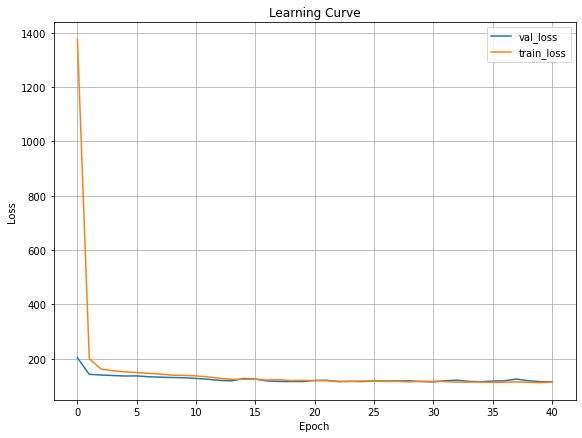

In [28]:
plt.figure(figsize=(8,6))
plt.title('Learning Curve')
plt.plot(d['val_loss'])
plt.plot(d['loss'])
plt.legend(['val_loss','train_loss'])
plt.tight_layout()
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch');

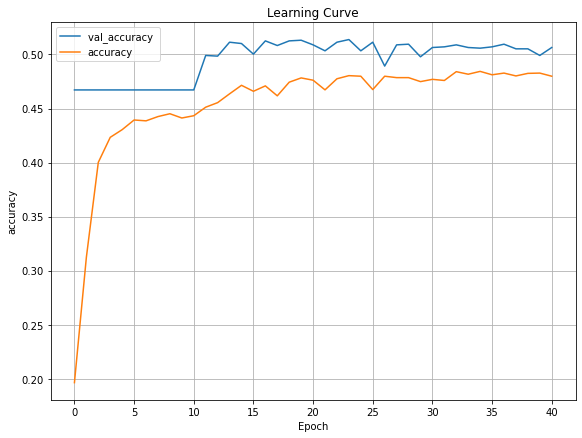

In [29]:
plt.figure(figsize=(8,6))
plt.title('Learning Curve')
plt.plot(d['val_accuracy'])
plt.plot(d['accuracy'])
plt.legend(['val_accuracy ','accuracy'])
plt.tight_layout()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('Epoch');

In [30]:
df = pd.DataFrame()
for e in y_cols:
    tmp = pd.DataFrame()
    tmp[ID] = [f'{c}_{e}' for c in test[ID].values]
    tmp['Predicted'] = predicted_set[e]
    df = pd.concat([df, tmp])

In [31]:
submission = pd.merge(sample_submission, df, on = 'Id')[['Id', 'Predicted_y']]
submission.columns = ['Id', 'Predicted']
submission.to_csv('submission.csv', index=False)
submission.head()

,Id,Predicted
0,10003_age,59.353821
1,10003_domain1_var1,54.373001
2,10003_domain1_var2,60.840408
3,10003_domain2_var1,50.414108
4,10003_domain2_var2,52.140896
